# Mineração de Dados
---
## Trabalho 3 - Regras de Associação

- **Alunos**: Gabriel Faria e Vinicius Oliveira

- **Objetivo**: Elaborar e analisar regras de associação para recomendação de artistas musicais.

- **Etapas**:
  - Carregar e examinar os dados.
  - Transformar os dados para um formato tratável.
  - Gerar regras de associação considerando a base de dados inteira e alguns subgrupos de interesse.
  - Recomendação de artistas e estratégias de marketing focadas.
  - Analisar e apresentar os resultados obtidos.

In [30]:
# Importações
import os
import networkx as nx

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

#### Função que gera resultados e salva os dados do modelo em disco
- Essa função salva os itemsets em disco para não ser necessário gerar sempre esses dados
- Fazemos assim um cache, para ser mais rápido as próximas execuções
- No caso de não ter o arquivo com o mínimo de suporte requerido, ele roda o algoritmo **Apriori**
- Nisso ele gera o resultado e salva

In [31]:
def get_itemsets(transactions, min_support, name):
    file_path = f"data/itemsets_{name}_{min_support}.csv"
    if not os.path.isfile(file_path):
        itemsets = apriori(transactions, min_support=min_support, use_colnames=True)
        itemsets.to_csv(file_path, index=False)
    else:
        itemsets = pd.read_csv(
            file_path, converters={"itemsets": lambda x: set(eval(x))}
        )
    return itemsets


#### Função que gera o o grafo com as regras de associação
- Esta função utiliza os antecedente e consequentes do estudo e gera um grafo
- Esse grafo é construído a partir dos vértices de cada artista
- E cria arcos indo do antecedente para o consequente

In [32]:

def graph_rules(rules):
    edges = {"antecedents": [], "consequents": []}
    for _, row in rules.iterrows():
        for antecedent in row["antecedents"]:
            for consequent in row["consequents"]:
                edges["antecedents"].append(antecedent)
                edges["consequents"].append(consequent)

    edges = pd.DataFrame.from_dict(edges)
    G = nx.from_pandas_edgelist(edges, source="antecedents", target="consequents")
    pos = nx.spring_layout(G, k=0.25)
    plt.figure(3, figsize=(16, 8))
    nx.draw(G, pos=pos, with_labels=True, arrows=True)
    plt.show()

    return edges

#### Leitura dos dados

In [33]:
# Leitura dos dados
df = pd.read_csv("data/data.csv")
df

,idUsuario,artista,sexo,pais
0,5,dream theater,m,Finland
1,5,ac/dc,m,Finland
2,5,metallica,m,Finland
3,5,iron maiden,m,Finland
4,5,bob marley & the wailers,m,Finland
...,...,...,...,...
58450,19714,led zeppelin,m,United Kingdom
58451,19714,slipknot,m,United Kingdom
58452,19714,children of bodom,m,United Kingdom
58453,19714,vader,m,United Kingdom


### Análise Exploratória
---
#### Análise inicial e entendimento da base que iremos trabalhar
- Análises gerais de entendimento da base
- 71,8% são do sexo masculino
- Talvez se os gêneros fossem diferentes teríamos uma distribuição com maior quantidade de mulheres?
- Dos 10 países com mais usuários, EUA representa quase 30%
- Quantidade de usuários por país, EUA se sobressai diante dos outros

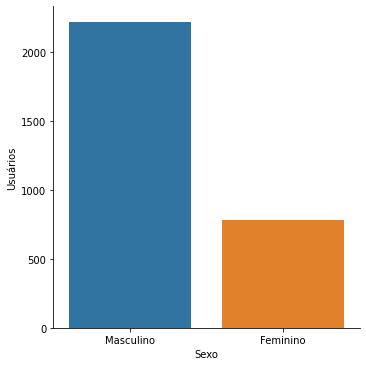

In [34]:
g = sns.catplot(data=df.groupby("idUsuario").first(), x="sexo", kind="count")
g.set_ylabels("Usuários")
g.set_xlabels("Sexo")
g.set_xticklabels(["Masculino", "Feminino"])

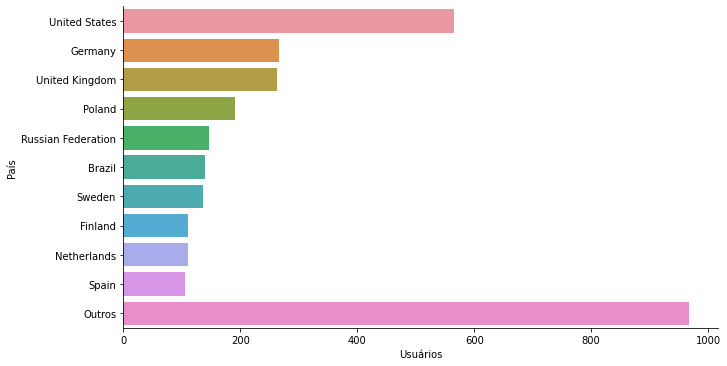

In [64]:
df_gp = df.groupby("idUsuario").first()

freq = list(df_gp["pais"].value_counts().index[:10])

df_in = df_gp[df_gp["pais"].isin(freq)]
df_out = df_gp[~df_gp["pais"].isin(freq)].copy()
df_out["pais"] = "Outros"

g = sns.catplot(
    data=pd.concat([df_in, df_out]),
    y="pais",
    kind="count",
    aspect=2,
    order=freq + ["Outros"],
    orient="h",
)
g.set_ylabels("País")
g.set_xlabels("Usuários")

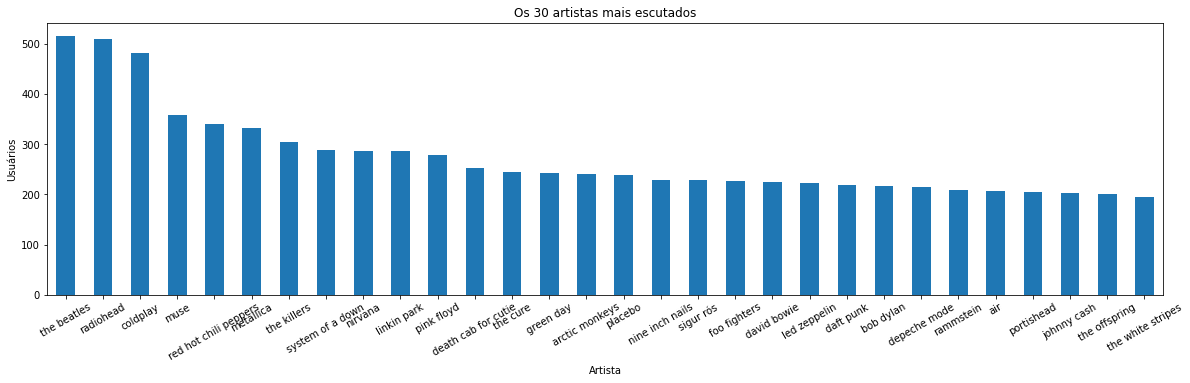

In [65]:
df.groupby("artista")["idUsuario"].count().reset_index().rename(
    columns={"idUsuario": "qtdUsuarios"}
).sort_values("qtdUsuarios", ascending=False)[:30].plot(
    "artista", "qtdUsuarios", kind="bar", figsize=(20, 5), rot=30, legend=None
)
plt.ylabel("Usuários")
plt.xlabel("Artista")
plt.title("Os 30 artistas mais escutados");

Text(0.5, 1.0, 'Os 10 países com mais usuários')

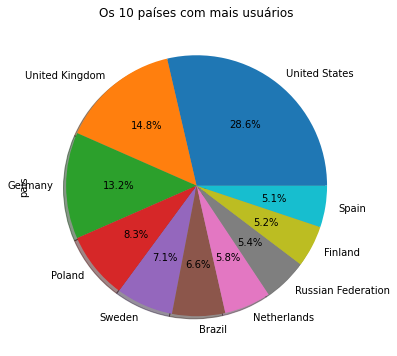

In [37]:
pie_countries = df.pais.value_counts().index[0:10]

df[df.pais.isin(pie_countries)].pais.value_counts().plot(kind='pie', shadow=True, figsize=(6, 6), autopct='%1.1f%%')
plt.title('Os 10 países com mais usuários')

Text(0.5, 1.0, 'Distribuição de gênero')

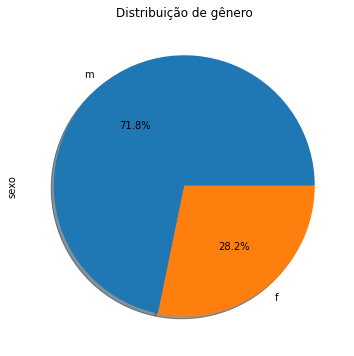

In [38]:
df.sexo.value_counts().plot(kind='pie', shadow=True, figsize=(6, 6), autopct='%1.1f%%')
plt.title('Distribuição de gênero')

Vemos abaixo um gráfico de proporção que mostra a partir da quantidade de artistas, a proporção deles na base

Nisso concluímos que os 200 artistas que mais aparecem no dataset, aparece em torno de 50% das vezes

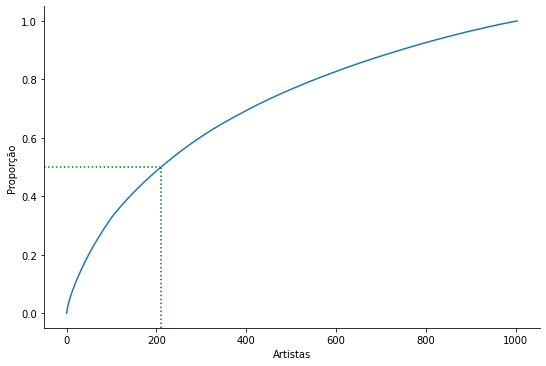

In [39]:
artists = list(df["artista"].value_counts())

total = sum(artists)
proportions = []
midpoint = None
for i in range(len(artists)):
    proportions.append(sum(artists[:i]) / total)
    if midpoint is None and proportions[-1] >= 0.5:
        midpoint = i

data = pd.DataFrame()
data["Proporção"] = proportions

g = sns.relplot(data=data, kind="line", aspect=1.5, legend=False)
g.ax.set_xlabel("Artistas")
g.ax.set_ylabel("Proporção")
g.ax.axvline(x=midpoint, ymax=0.5, color="g", linestyle="dotted")
g.ax.axhline(
    y=0.5, xmin=0, xmax=(midpoint / len(artists)) + 0.023, color="g", linestyle="dotted"
)

Vemos nesse gráfico a quantidade única de artistas por cad usuários, e vemos que em média os usuários escutam em torno de 20 artistas

Tal fato pode ajudar na recomendação de artistas que aparecem frequentemente juntos de acordo com o gosto dos usuários. Nesse caso, podendo ser usado para os usuários que usam pouco a plataforma ou escutem menos de 10 artistas, gastam pouco tempo na plataforma, recomendar para esse com base em chegar a pelo menos 20 artistas e uma utilização maior na plataforma.

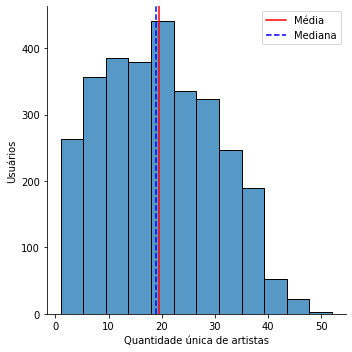

In [40]:
data = df["idUsuario"].value_counts()
g = sns.displot(data=data, bins=12)
g.ax.axvline(x=data.mean(), color="red")
g.ax.axvline(x=data.median(), color="blue", ls="--")
g.ax.legend(["Média", "Mediana"])
g.ax.set_xlabel("Quantidade única de artistas")
g.ax.set_ylabel("Usuários");

# Transformando a base para ser utilizada nas análises
- Entender se as ocorrências a frequência com que um itemset de mesmos artistas acontecem
- Co-ocorrências de um conjunto de artistas para vários usuários
- Extrair itemsets frequentes, para extrair regras de associação dos conjuntos

### Tratamento e Pré Processamento
---
- Conversão para variáveis dummies, com variáveis indicadoras
- Cada coluna possui indicação de um artista
- Cada linha é uma usuário, a coluna indica se o usuário possui o artista na lista

### Regras de Associação (Geral)


In [41]:
transactions = df.groupby("idUsuario")["artista"].aggregate(list)
transactions

idUsuario
5        [dream theater, ac/dc, metallica, iron maiden,...
9        [arch enemy, strapping young lad, kreator, chi...
14       [sonic youth, the fall, mogwai, the velvet und...
22       [the jam, maxïmo park, supergrass, simon & gar...
24       [the byrds, leonard cohen, the beatles, simon ...
                               ...                        
19688    [bullet for my valentine, escape the fate, 30 ...
19701    [placebo, animal collective, crystal castles, ...
19703    [the offspring, pearl jam, the smashing pumpki...
19708    [coldplay, amy winehouse, armin van buuren, mo...
19714    [misfits, type o negative, arch enemy, red hot...
Name: artista, Length: 3000, dtype: object

In [42]:
encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)
df_t

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,[unknown],...,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7,Édith piaf
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2997,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Análises dos dados para construção das regras de associação
---
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

Suporte é a quantidade de transações que contêm elementos no itemset

Abaixo temos o suporte e o suporte relativo

Cardinalidade dos elementos associados aos artistas para cada usuário

Ter um suporte mínimo, que é o limiar de suporte mínimo, para gerar os itemsets frequentes, para depois gerar as regras

#### Info
- dataset transacional
- min_suport é o suporte relativo
- real_support é a quantidade de vezes que o itemset aparece
- o support na biblioteca nada mais é que o suporte relativo

In [43]:
itemsets = get_itemsets(df_t, min_support=0.005, name="all")
rules = association_rules(itemsets, metric="confidence", min_threshold=0.5).sort_values(
    by="lift", ascending=False
)
rules["absolute_support"] = (rules["support"] * len(transactions)).apply(round)

- Lift é uma medida de correlação associada a X e Y (onde X -> Y é a regra de associação)
- Lifts pode ser usado para fazer avaliação de ordem, para buscar regras de interesse a partir dessa métrica
- Leverage e Conviction também são outras métricas possíveis que podemso usar para avaliar as regras de associação
- Podemos até mesmo ordenar de acordo com qual métrica queremos avaliar

### Visualizando os resultados das métricas

referencia: https://intelligentonlinetools.com/blog/2018/02/10/how-to-create-data-visualization-for-association-rules-in-data-mining/

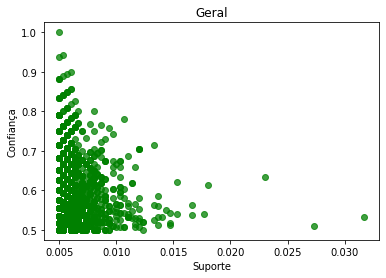

In [44]:
plt.scatter(rules["support"], rules["confidence"], alpha=0.75, c="g")
plt.xlabel("Suporte")
plt.ylabel("Confiança")
plt.title("Geral")
plt.show()

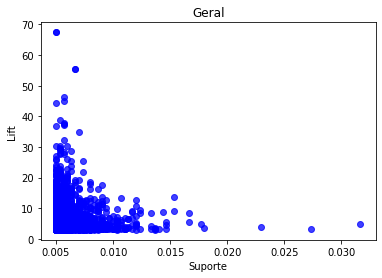

In [66]:
plt.scatter(rules["support"], rules["lift"], alpha=0.75, c="b")
plt.xlabel("Suporte")
plt.ylabel("Lift")
plt.title("Geral")
plt.show()

- Usamos a bilioteca Numpy para gerar uma possível tendência
- Para isso utilizamos do método dos mínimos quadrados para determinar o ajuste de mínimos quadrados
- Em outras bases, poderíamos ver uma tendência entre as métricas

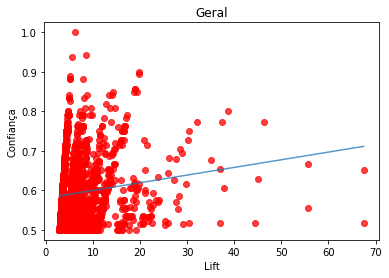

In [46]:
fit = np.polyfit(rules["lift"], rules["confidence"], 1)
fit_fn = np.poly1d(fit)
plt.plot(
    rules["lift"],
    rules["confidence"],
    "ro",
    rules["lift"],
    fit_fn(rules["lift"]),
    alpha=0.75,
)
plt.xlabel("Lift")
plt.ylabel("Confiança")
plt.title("Geral")
plt.show()

- Usamos uma configuração de suporte relativo baixo para buscarmos diversas regras de associação
- Para gerar os itemsets, usamos a função get_itemsets, que foi a função criada no início do notebook
- Usamos um valor de suporte relativo de 0.01 para termos diversos itemset e podermos gerar ainda mais regras de associação

In [47]:
itemsets = get_itemsets(df_t, min_support=0.01, name="all")
itemsets 

,support,itemsets
0,0.011667,{...and you will know us by the trail of dead}
1,0.025333,{2pac}
2,0.031333,{3 doors down}
3,0.033333,{30 seconds to mars}
4,0.011333,{311}
...,...,...
1811,0.010333,"{the beatles, radiohead, sigur rós}"
1812,0.012000,"{the beatles, the cure, radiohead}"
1813,0.011333,"{the beatles, the smashing pumpkins, radiohead}"
1814,0.010667,"{the white stripes, the beatles, radiohead}"


In [48]:
rules_all = association_rules(
    itemsets, metric="confidence", min_threshold=0.5
).sort_values(by="lift", ascending=False)
rules_all["absolute_support"] = (rules_all["support"] * len(transactions)).apply(round)
rules_all

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
2,(beyoncé),(rihanna),0.024667,0.045333,0.015333,0.621622,13.712242,0.014215,2.523048,46
22,(the pussycat dolls),(rihanna),0.017667,0.045333,0.010667,0.603774,13.318535,0.009866,2.409397,32
68,"(slipknot, system of a down)",(koЯn),0.020667,0.046000,0.012000,0.580645,12.622721,0.011049,2.274923,36
69,"(koЯn, system of a down)",(slipknot),0.022667,0.048667,0.012000,0.529412,10.878324,0.010897,2.021583,36
61,"(metallica, megadeth)",(iron maiden),0.017667,0.059333,0.010333,0.584906,9.857961,0.009285,2.266152,31
...,...,...,...,...,...,...,...,...,...,...
53,"(david bowie, the cure)",(radiohead),0.019667,0.169667,0.010333,0.525424,3.096800,0.006997,1.749631,31
23,(simon & garfunkel),(the beatles),0.026333,0.172000,0.014000,0.531646,3.090963,0.009471,1.767892,42
0,(andrew bird),(radiohead),0.020333,0.169667,0.010333,0.508197,2.995266,0.006883,1.688344,31
24,(the flaming lips),(the beatles),0.026667,0.172000,0.013667,0.512500,2.979651,0.009080,1.698462,41


In [49]:
rules_all.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,0.022120,0.126932,0.012466,0.571181,5.299400,0.009683,2.085507,37.397436
std,0.007160,0.044218,0.003607,0.060978,2.550384,0.002917,0.373761,10.822463
min,0.013667,0.045333,0.010000,0.500000,2.947920,0.006776,1.679657,30.000000
25%,0.018083,0.096000,0.010333,0.530540,3.315713,0.007903,1.839296,31.000000
50%,0.020667,0.160667,0.011333,0.549835,4.472748,0.008991,1.969791,34.000000
75%,0.023667,0.169667,0.013333,0.601869,6.295788,0.010300,2.200563,40.000000
max,0.059333,0.172000,0.031667,0.780488,13.712242,0.025081,3.782630,95.000000


#### Análise gráfica dos resultados por meio de grafos
- Usamos a biblioteca NetworkX para construir um gráfico de rede para verificar a associação entre antecedentes e consequentes obtidos após a regra de associação
- Achamos alguns grupo que se combinam, podendo ser artistas que as pessoas costumam sempre ouvir, dado que ouve outra
- Vemos vários grupos de artistas que podem ser de estilos parecidos, em que gostos musicais se alinham com esses artistas
- A partir disso, podemos recomendar artistas, de acordo com cada agrupamento visto no grafo abaixo

referencia: https://www.kaggle.com/bbhatt001/bakery-business-model-association-rules

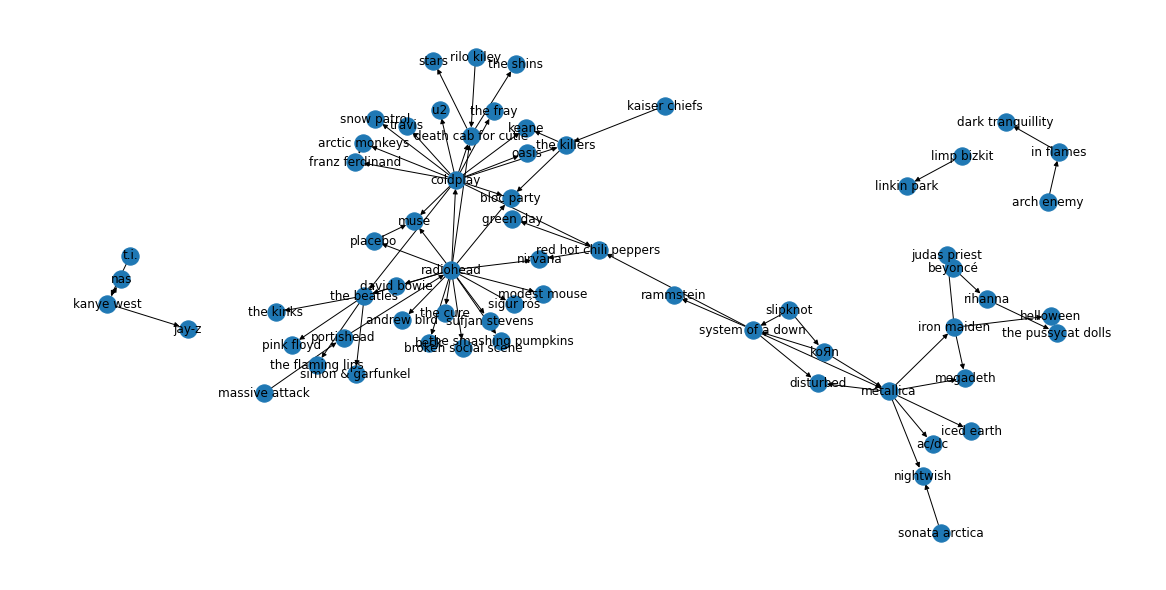

In [50]:
edges = graph_rules(rules_all)

- Filtramos após isso, todos os antecedentes e consequentes que possuem Metallica
- Com isso podemos ver fielmente quais bandas geralmente as pessoas escutam a partir de que escutam Metallica
- De acordo com o gosto musical, faz sentido na prática essas bandas estarem juntas
- A partir disso, podemos pensar em um sistema de recomendação que cria rádios de artistas
- Com essa análise, podemos recomendar esses artistas, dado que a pessoa gosta desse gênero de música e frequentemente escuta Metallica

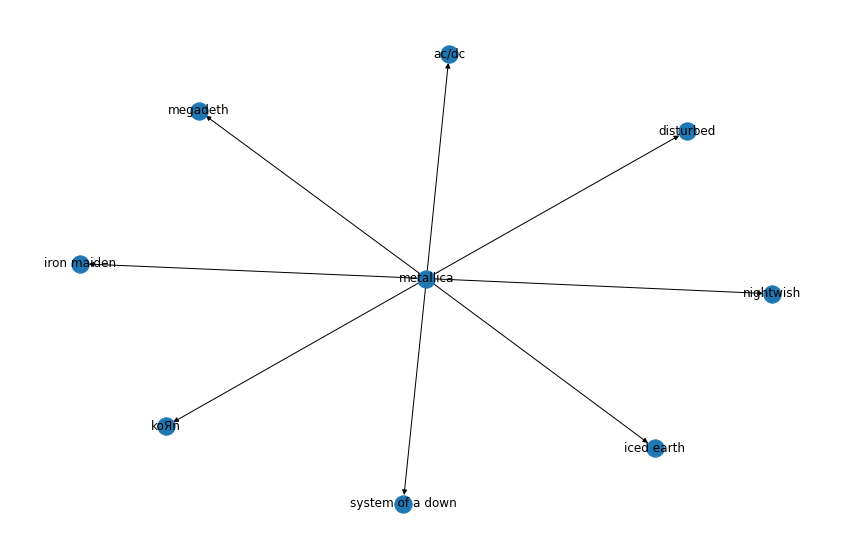

In [63]:
metallica_edges = edges[(edges.antecedents.str.contains('metallica', case=False)) | (edges.consequents.str.contains('metallica', case=False))]

fig, ax = plt.subplots(figsize=(15, 10))
G = nx.from_pandas_edgelist(
    metallica_edges, source="antecedents", target="consequents"
)
nx.draw(G, with_labels=True, arrows=True)
plt.show()

- Os próximos resultados foram gerados parecido das formas anteriores
- Neste caso trouxemos algumas regras diferentes, com grupos de sexo, pais e misto
- Tentando encontrar diferenciações na análise

### Regras de Associação (Sexo Masculino)


In [52]:
transactions = df[df["sexo"] == "m"].groupby("idUsuario")["artista"].aggregate(list)
transactions

idUsuario
5        [dream theater, ac/dc, metallica, iron maiden,...
9        [arch enemy, strapping young lad, kreator, chi...
14       [sonic youth, the fall, mogwai, the velvet und...
22       [the jam, maxïmo park, supergrass, simon & gar...
24       [the byrds, leonard cohen, the beatles, simon ...
                               ...                        
19677    [doves, the new pornographers, the weakerthans...
19685    [philip glass, rammstein, pink floyd, moby, bl...
19688    [bullet for my valentine, escape the fate, 30 ...
19708    [coldplay, amy winehouse, armin van buuren, mo...
19714    [misfits, type o negative, arch enemy, red hot...
Name: artista, Length: 2219, dtype: object

In [53]:
encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)

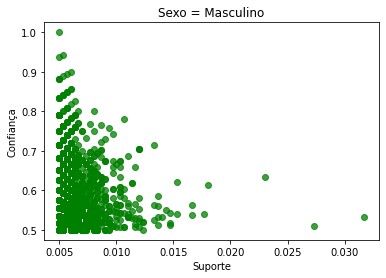

In [54]:
itemsets = get_itemsets(df_t, min_support=0.005, name="all")
rules = association_rules(itemsets, metric="confidence", min_threshold=0.5).sort_values(
    by="lift", ascending=False
)
plt.scatter(rules["support"], rules["confidence"], alpha=0.75, c="g")
plt.xlabel("Suporte")
plt.ylabel("Confiança")
plt.title("Sexo = Masculino")
plt.show()

In [55]:
itemsets = get_itemsets(df_t, min_support=0.01, name="sexo")
itemsets

,support,itemsets
0,0.011717,{...and you will know us by the trail of dead}
1,0.029743,{2pac}
2,0.027039,{3 doors down}
3,0.030194,{30 seconds to mars}
4,0.013069,{311}
...,...,...
1617,0.010365,"{red hot chili peppers, pink floyd, radiohead}"
1618,0.010365,"{red hot chili peppers, the beatles, radiohead}"
1619,0.010816,"{the beatles, the cure, radiohead}"
1620,0.010365,"{the beatles, the smashing pumpkins, radiohead}"


In [56]:
rules_male = association_rules(
    itemsets, metric="confidence", min_threshold=0.5
).sort_values(by="lift", ascending=False)
rules_male["absolute_support"] = (rules_male["support"] * len(transactions)).apply(
    round
)
rules_male

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
27,(kreator),(slayer),0.015773,0.043713,0.010365,0.657143,15.032990,0.009676,2.789169,23
39,"(ac/dc, iron maiden)",(judas priest),0.022533,0.035151,0.011717,0.520000,14.793333,0.010925,2.010102,26
10,(death),(slayer),0.018026,0.043713,0.010816,0.600000,13.725773,0.010028,2.390717,24
72,"(slipknot, linkin park)",(koЯn),0.016224,0.054078,0.011266,0.694444,12.841435,0.010389,3.095743,25
55,"(slipknot, disturbed)",(koЯn),0.017125,0.054078,0.010816,0.631579,11.678947,0.009890,2.567501,24
...,...,...,...,...,...,...,...,...,...,...
49,"(coldplay, sigur rós)",(radiohead),0.022533,0.161785,0.011717,0.520000,3.214150,0.008072,1.746282,26
45,"(bob dylan, radiohead)",(the beatles),0.021181,0.161334,0.010816,0.510638,3.165102,0.007399,1.713796,24
47,"(coldplay, oasis)",(radiohead),0.020279,0.161785,0.010365,0.511111,3.159208,0.007084,1.714532,23
90,"(red hot chili peppers, pink floyd)",(radiohead),0.020279,0.161785,0.010365,0.511111,3.159208,0.007084,1.714532,23


In [57]:
rules_male.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.023177,0.107498,0.013035,0.569987,6.276209,0.010527,2.119001,28.924731
std,0.007943,0.039533,0.003991,0.056576,2.902529,0.003173,0.350450,8.855404
min,0.015322,0.035151,0.010365,0.500000,3.090529,0.007084,1.676431,23.000000
25%,0.018927,0.064443,0.010816,0.526316,4.069469,0.008642,1.871113,24.000000
50%,0.020730,0.111311,0.011717,0.547619,5.285522,0.009890,1.988111,26.000000
75%,0.023885,0.142857,0.013970,0.607843,8.300049,0.011018,2.289038,31.000000
max,0.072555,0.161785,0.038756,0.750000,15.032990,0.029470,3.488058,86.000000


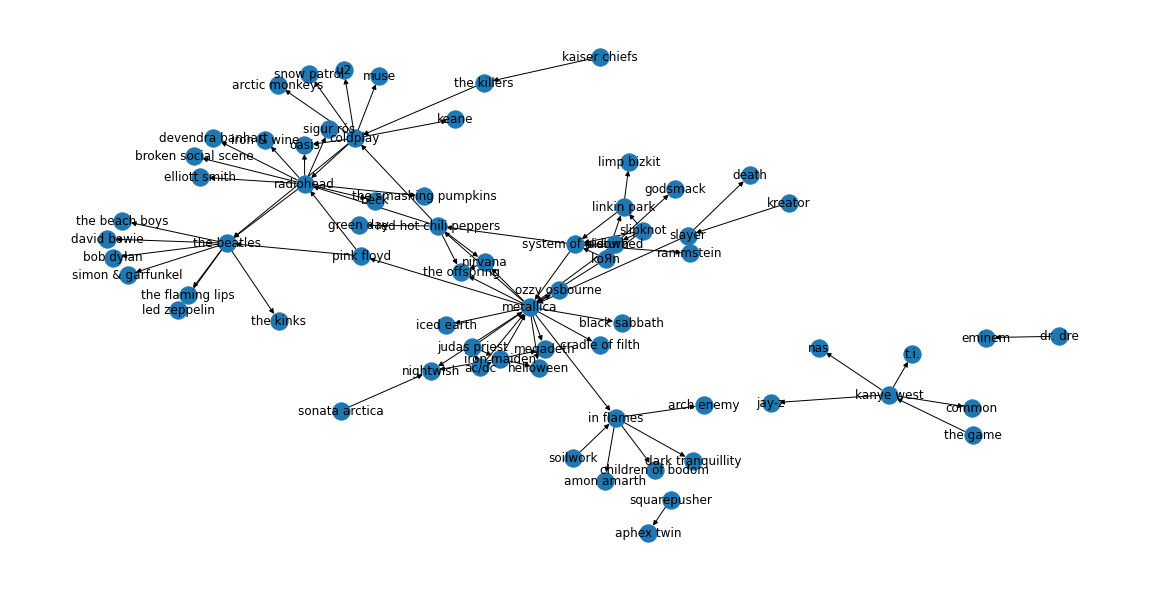

In [58]:
graph_rules(rules_male);

### Regras de Associação (Estados Unidos)

In [29]:
transactions = (
    df[df["pais"] == "United States"].groupby("idUsuario")["artista"].aggregate(list)
)
transactions

idUsuario
9        [arch enemy, strapping young lad, kreator, chi...
32       [nick cave and the bad seeds, black flag, the ...
44       [girl talk, roxette, kings of leon, my morning...
45       [the dandy warhols, the beatles, the stone ros...
177      [john williams, death cab for cutie, the white...
                               ...                        
19625    [reel big fish, green day, queen, tenacious d,...
19632    [sage francis, regina spektor, cocteau twins, ...
19649    [norah jones, phoenix, no doubt, black eyed pe...
19650    [the mountain goats, saves the day, against me...
19701    [placebo, animal collective, crystal castles, ...
Name: artista, Length: 566, dtype: object

In [66]:
encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)

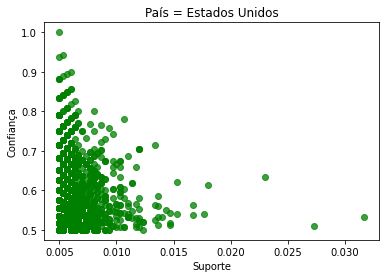

In [67]:
itemsets = get_itemsets(df_t, min_support=0.005, name="all")
rules = association_rules(itemsets, metric="confidence", min_threshold=0.5).sort_values(
    by="lift", ascending=False
)
plt.scatter(rules["support"], rules["confidence"], alpha=0.75, c="g")
plt.xlabel("Suporte")
plt.ylabel("Confiança")
plt.title("País = Estados Unidos")
plt.show()

In [68]:
itemsets = get_itemsets(df_t, min_support=0.02, name="pais")
itemsets

,support,itemsets
0,0.035336,{2pac}
1,0.031802,{311}
2,0.030035,{50 cent}
3,0.031802,{a perfect circle}
4,0.044170,{a tribe called quest}
...,...,...
807,0.021201,"{death cab for cutie, beck, radiohead, modest ..."
808,0.021201,"{the beatles, death cab for cutie, beck, radio..."
809,0.024735,"{the beatles, beck, radiohead, modest mouse}"
810,0.022968,"{the beatles, beck, radiohead, the shins}"


In [69]:
rules_us = association_rules(
    itemsets, metric="confidence", min_threshold=0.5
).sort_values(by="lift", ascending=False)
rules_us["absolute_support"] = (rules_us["support"] * len(transactions)).apply(round)
rules_us

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
53,(say anything),(taking back sunday),0.040636,0.051237,0.021201,0.521739,10.182909,0.019119,1.983778,12
29,(frou frou),(imogen heap),0.038869,0.056537,0.021201,0.545455,9.647727,0.019004,2.075618,12
178,"(death cab for cutie, beck)","(radiohead, modest mouse)",0.035336,0.068905,0.021201,0.600000,8.707692,0.018767,2.327739,12
171,(wilco),"(the beatles, radiohead)",0.030035,0.104240,0.021201,0.705882,6.771685,0.018071,3.045583,12
182,"(death cab for cutie, beck)","(the beatles, radiohead)",0.035336,0.104240,0.021201,0.600000,5.755932,0.017518,2.239399,12
...,...,...,...,...,...,...,...,...,...,...
35,(john mayer),(the beatles),0.051237,0.268551,0.026502,0.517241,1.926044,0.012742,1.515144,15
4,(arcade fire),(the beatles),0.079505,0.268551,0.040636,0.511111,1.903216,0.019285,1.496145,23
109,"(coldplay, radiohead)",(the beatles),0.077739,0.268551,0.038869,0.500000,1.861842,0.017992,1.462898,22
68,"(coldplay, beck)",(the beatles),0.042403,0.268551,0.021201,0.500000,1.861842,0.009814,1.462898,12


In [70]:
rules_us.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.045420,0.211335,0.027426,0.624237,3.193536,0.017720,inf,15.523077
std,0.018817,0.051999,0.009846,0.109778,1.199426,0.005902,NaN,5.572690
min,0.021201,0.051237,0.021201,0.500000,1.861842,0.009814,1.462898,12.000000
25%,0.035336,0.181979,0.021201,0.540570,2.345130,0.014450,1.747114,12.000000
50%,0.040636,0.233216,0.022968,0.600000,2.976537,0.016257,1.963251,13.000000
75%,0.052120,0.233216,0.030035,0.685855,3.757387,0.018779,2.453887,17.000000
max,0.134276,0.268551,0.081272,1.000000,10.182909,0.049957,inf,46.000000


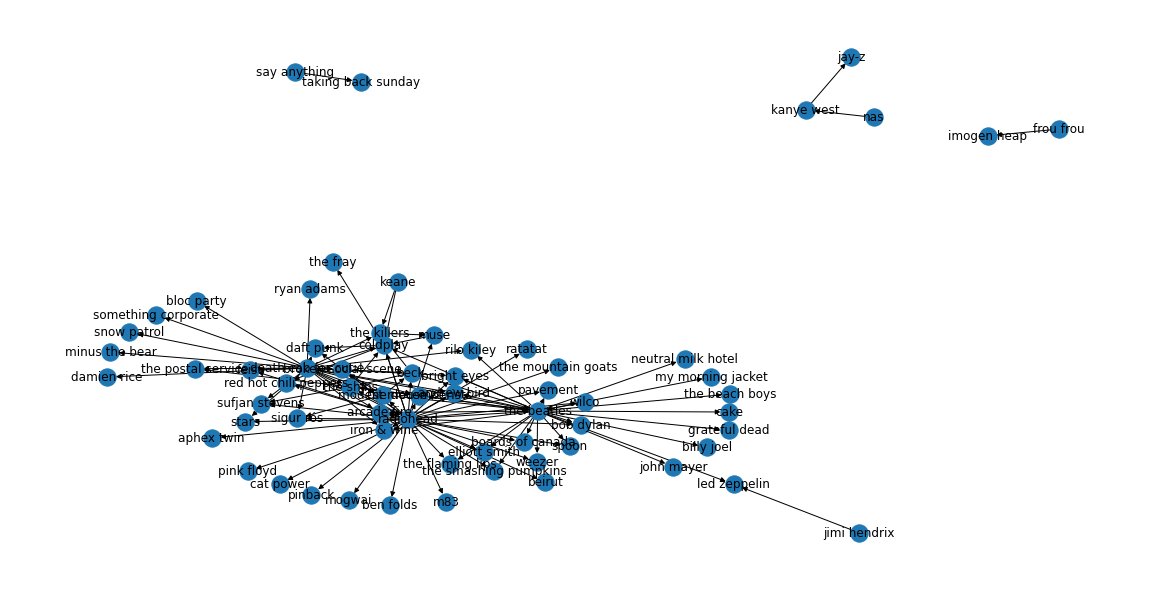

In [71]:
graph_rules(rules_us)

### Regras de Associação (Mistura)

In [72]:
# Misturar artistas e características dos usuários
df_info = df.groupby("idUsuario").first()
df_info["idUsuario"] = df_info.index

df_gender = df_info[["idUsuario", "sexo"]].rename(columns={"sexo": "item"})
df_country = df_info[["idUsuario", "pais"]].rename(columns={"pais": "item"})

df_mix = df[["idUsuario", "artista"]].rename(columns={"artista": "item"})
df_mix = pd.concat([df_mix, df_gender, df_country], ignore_index=True)
df_mix

,idUsuario,item
0,5,dream theater
1,5,ac/dc
2,5,metallica
3,5,iron maiden
4,5,bob marley & the wailers
...,...,...
64450,19688,Italy
64451,19701,United States
64452,19703,Poland
64453,19708,Brazil


In [73]:
transactions = df_mix.groupby("idUsuario")["item"].aggregate(list)
transactions

idUsuario
5        [dream theater, ac/dc, metallica, iron maiden,...
9        [arch enemy, strapping young lad, kreator, chi...
14       [sonic youth, the fall, mogwai, the velvet und...
22       [the jam, maxïmo park, supergrass, simon & gar...
24       [the byrds, leonard cohen, the beatles, simon ...
                               ...                        
19688    [bullet for my valentine, escape the fate, 30 ...
19701    [placebo, animal collective, crystal castles, ...
19703    [the offspring, pearl jam, the smashing pumpki...
19708    [coldplay, amy winehouse, armin van buuren, mo...
19714    [misfits, type o negative, arch enemy, red hot...
Name: item, Length: 3000, dtype: object

In [74]:
encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)

In [75]:
itemsets = get_itemsets(df_t, min_support=0.01, name="mix")
itemsets

,support,itemsets
0,0.011667,{...and you will know us by the trail of dead}
1,0.025333,{2pac}
2,0.031333,{3 doors down}
3,0.033333,{30 seconds to mars}
4,0.011333,{311}
...,...,...
3117,0.011667,"{the beatles, m, United States, radiohead}"
3118,0.011667,"{the beatles, m, radiohead, coldplay}"
3119,0.010000,"{system of a down, metallica, koЯn, m}"
3120,0.010667,"{slipknot, system of a down, koЯn, m}"


Vemos nesse caso que a métrica confidence muda de acordo com a regra de associação, as vezes associada também ao sexo masculino
e a algum outro artista. Quando ele faz a mesma regra de associação, porém sem associar o sexo, a métrica diminui.

Esse comportamento pode-se explicar, de acordo com o gosto musical, que muitas vezes é diferente entre os sexos.

In [76]:
rules_mix = association_rules(
    itemsets, metric="confidence", min_threshold=0.5
).sort_values(by="lift", ascending=False)
rules_mix["absolute_support"] = (rules_mix["support"] * len(transactions)).apply(round)

# Remover 'não-artistas' dos consequentes.
blacklist = list(df["sexo"].unique()) + list(df["pais"].unique())
mask = rules_mix["consequents"].apply(lambda x: any(b in x for b in blacklist))
rules_mix = rules_mix[~mask]
rules_mix

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
95,(beyoncé),(rihanna),0.024667,0.045333,0.015333,0.621622,13.712242,0.014215,2.523048,46
1113,"(system of a down, slipknot, m)",(koЯn),0.017333,0.046000,0.010667,0.615385,13.377926,0.009869,2.480400,32
537,(the pussycat dolls),(rihanna),0.017667,0.045333,0.010667,0.603774,13.318535,0.009866,2.409397,32
904,"(slipknot, system of a down)",(koЯn),0.020667,0.046000,0.012000,0.580645,12.622721,0.011049,2.274923,36
1115,"(system of a down, koЯn, m)",(slipknot),0.019333,0.048667,0.010667,0.551724,11.336797,0.009726,2.122205,32
...,...,...,...,...,...,...,...,...,...,...
806,"(f, sigur rós)",(radiohead),0.025000,0.169667,0.013000,0.520000,3.064833,0.008758,1.729861,39
1070,"(m, the beach boys)",(the beatles),0.021667,0.172000,0.011333,0.523077,3.041145,0.007607,1.736129,34
60,(andrew bird),(radiohead),0.020333,0.169667,0.010333,0.508197,2.995266,0.006883,1.688344,31
539,(the flaming lips),(the beatles),0.026667,0.172000,0.013667,0.512500,2.979651,0.009080,1.698462,41


In [77]:
rules_mix.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,absolute_support
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,0.022291,0.123756,0.012493,0.568119,5.456829,0.009754,2.078694,37.478992
std,0.007003,0.045485,0.003502,0.061030,2.597210,0.002832,0.378310,10.505728
min,0.013667,0.045333,0.010000,0.500000,2.947920,0.006776,1.679657,30.000000
25%,0.018333,0.084000,0.010667,0.526671,3.313461,0.008081,1.834520,32.000000
50%,0.020667,0.113667,0.011333,0.543860,4.636990,0.009116,1.955800,34.000000
75%,0.024667,0.169667,0.013333,0.596154,6.651081,0.010381,2.186468,40.000000
max,0.059333,0.172000,0.031667,0.780488,13.712242,0.025081,3.782630,95.000000


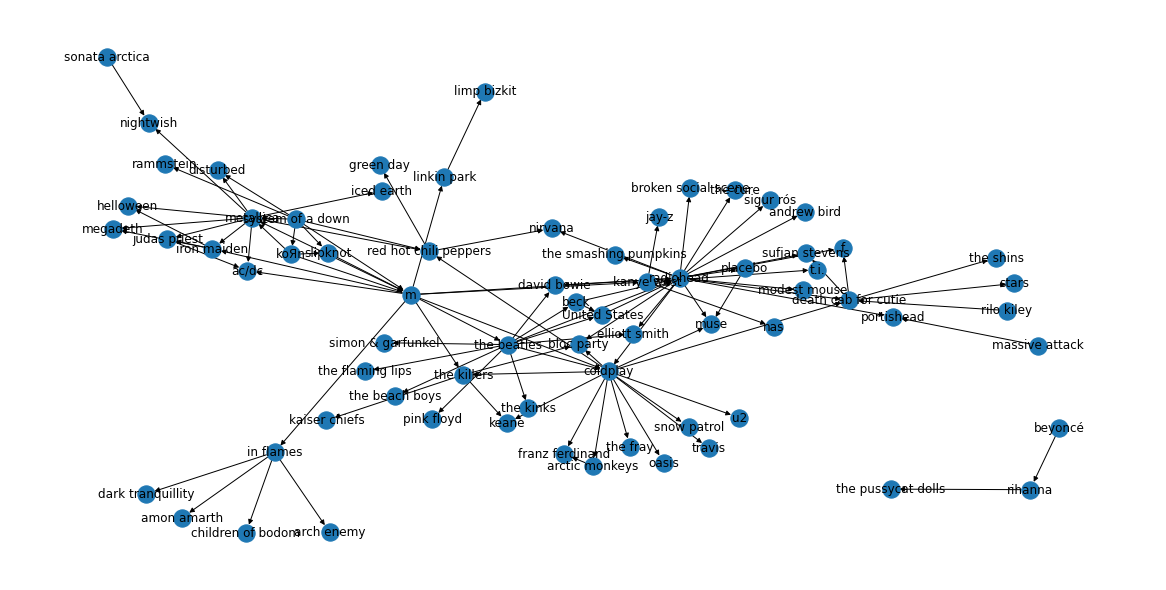

In [78]:
graph_rules(rules_mix)